<a id='start'></a>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель исследования:**<br>
Построить модель предсказания количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи иследования:

1. [Загрузить данные;](#step1)
2. [Выполнить ресемплирование данных по одному часу и проанализировать их;](#step2)
3. [Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных;](#step3)
4. [Проверить данные на тестовой выборке и сделать выводы;](#step4)
5. [Подвести итог.](#step5)



## Подготовка

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from catboost.utils import eval_metric

from statsmodels.tsa.seasonal import seasonal_decompose


<a id='step1'></a>

Загрузка данных. Сразу укажем столбец с датой, чтобы он точно был в нужном формате. Укажем столбец с датой в качестве индекса.

In [2]:
data_initial = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=[0])
data_initial.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Дату сделал индексом, тем самым преобразовал датафрейм во временной ряд.

На первый взгляд данные отсортированы по дате (далее проверим это), количество заказов находится в столбце 'num_orders'.

In [3]:
data_initial.idxmax()

num_orders   2018-08-13 02:20:00
dtype: datetime64[ns]

Данные предоставлены до 2018-08-13

<a id='step2'></a>

## Анализ

In [4]:
data_initial.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет

Убедимся, что данные отсортированы по дате

In [5]:
data_initial.index.is_monotonic

True

Построим график

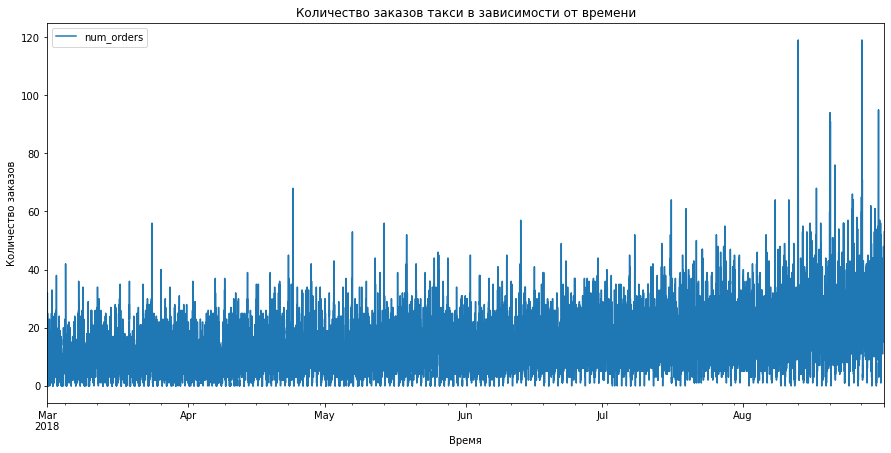

In [6]:
data_initial.plot(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси в зависимости от времени')
plt.show()

График плохо различим, построим заново график для промежутка с 6 по 7 июля для примера.

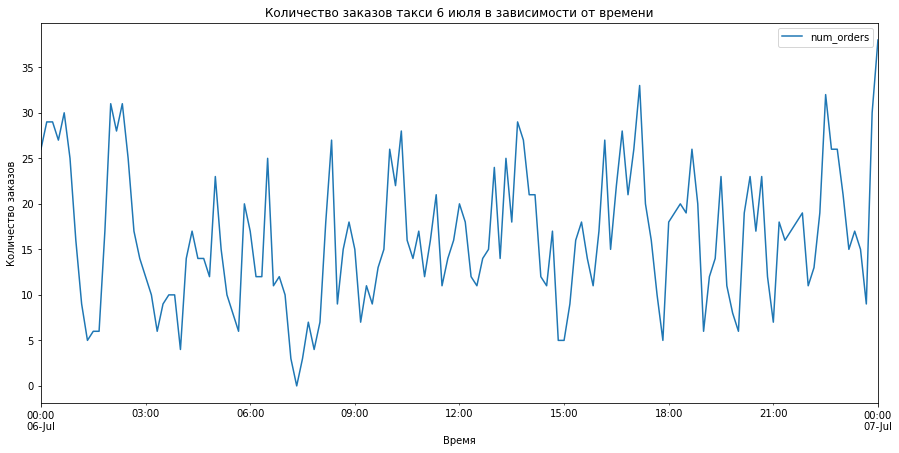

In [7]:
data_initial['2018-07-06 00:00':'2018-07-07 00:00'].plot(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси 6 июля в зависимости от времени')
plt.show()

Временной ряд выглядит стационарным.

Выполним ресемплирование по 1 часу

In [8]:
data = data_initial.copy()

In [9]:
data = data.resample('1H').sum()

In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Ресемплирование проведено корректно.

Посмотрим как поменялся график

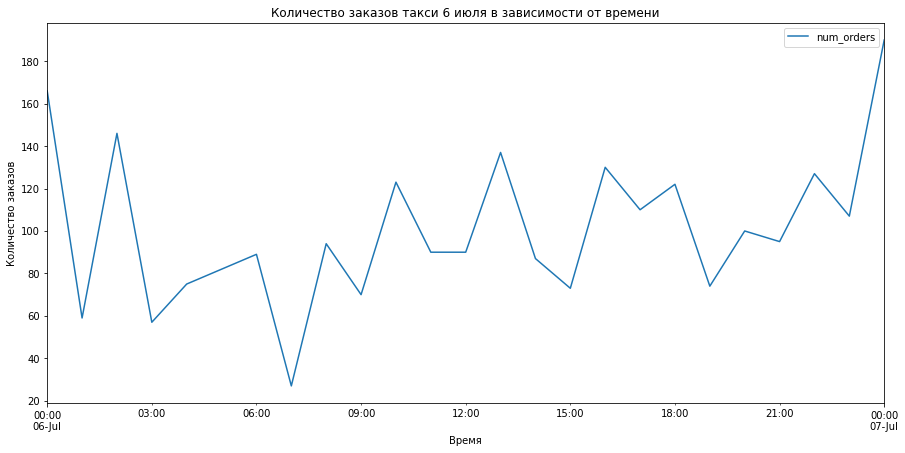

In [11]:
data['2018-07-06 00:00':'2018-07-07 00:00'].plot(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси 6 июля в зависимости от времени')
plt.show()

Видно, что шаг в данных уменьшился.

Создадим функцию, генерирующую новые признаки: год, месяц, день, день недели, отстающие значения и скользящее среднее

In [12]:
def make_features(data, max_lag, rolling_mean_size):
#     data['year'] = data.index.year
    data['month'] = data.index.month
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:, 0].shift(lag)


    data['rolling_mean'] = data.iloc[:, 0].shift().rolling(rolling_mean_size).mean()
    

Проверим работоспособность функции

In [13]:
data_check = data.copy()

In [14]:
make_features(data_check, 3, 3)

In [15]:
data_check.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,93.333333
2018-03-01 04:00:00,43,3,3,4,66.0,71.0,85.0,74.000000


Функция работает корректно.

Для примера построим график скользящего среднего для промежутка времени с 1 по 3 июля

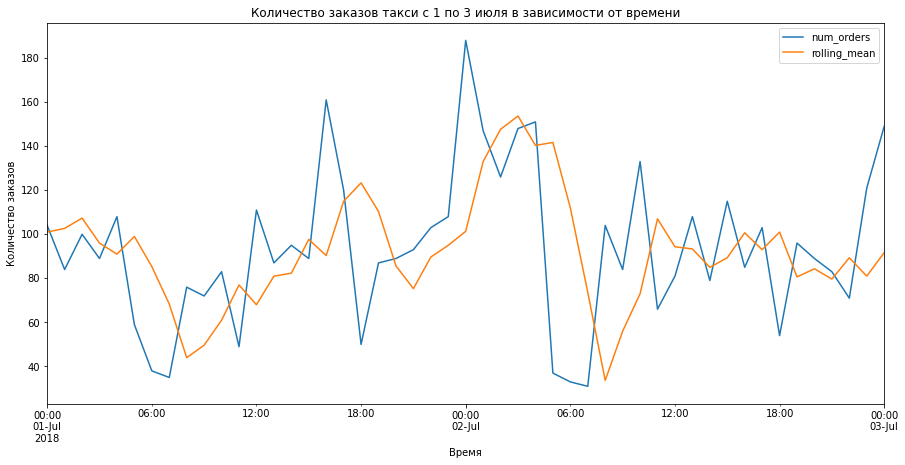

In [16]:
data_check['2018-07-01 00:00':'2018-07-03 00:00'].plot(y=['num_orders', 'rolling_mean'], figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси с 1 по 3 июля в зависимости от времени')
plt.show()

График выглядит корректно

Исследуем временной ряд на тренды и сезонность

In [17]:
decomposed = seasonal_decompose(data)

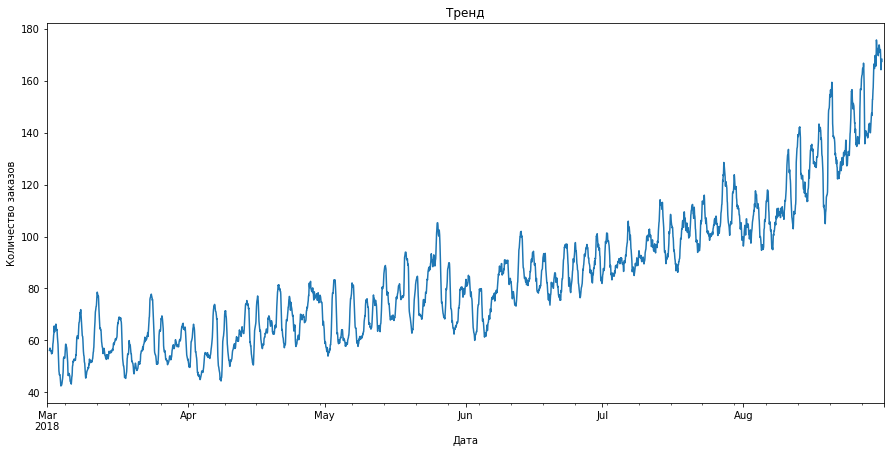

In [18]:
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 7))
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Общий тренд такой, что количество заказов с марта по август в целом постоянно растет.

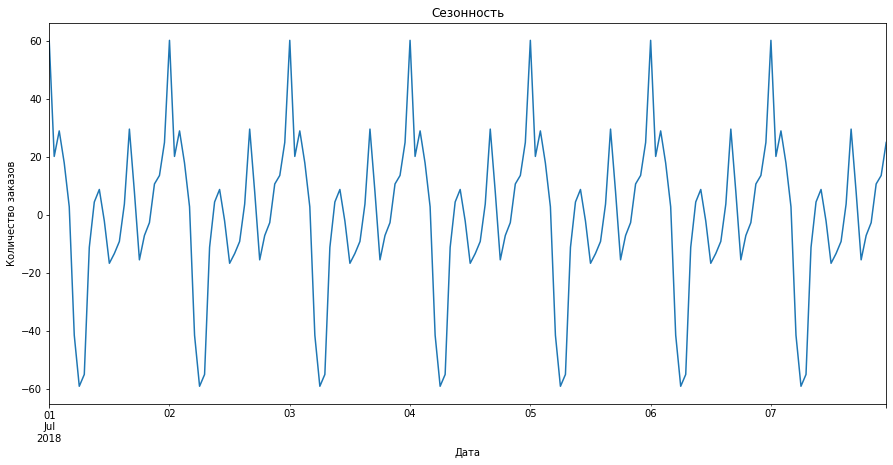

In [19]:
decomposed.seasonal['2018-07-01':'2018-07-07'].plot(ax=plt.gca(), figsize=(15, 7))
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Из графика видно, что период сезонности 1 сутки.

<a id='step3'></a>

## Обучение

Проведем обучение модели и проверим качество на обучающей выборке. На базе линейной регрессии подберем количество отстающих значений и размера окна скользящего среднего, при которых качество будет наибольшим.

*Линейная регрессия*

In [21]:
%%time

best_result_regr = 60
best_lag = 0
best_size = 0

for lag in tqdm(range(1, 41)):
    for size in range(1, 41):
        data_copy = data.copy()
        make_features(data_copy, lag, size)
        train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
        train = train.dropna()
        
        features_train = train.drop('num_orders', axis=1)
        features_test = test.drop('num_orders', axis=1)

        target_train = train['num_orders']
        target_test = test['num_orders']
        
        model = LinearRegression()
        model.fit(features_train, target_train)

        predict_test = model.predict(features_train)
        result = mean_squared_error(target_train, predict_test, squared=False)
        
        print(f'lag = {lag}; size = {size}; result = {result}')
        
        if result < best_result_regr:
            best_lag = lag
            best_size = size
            best_result_regr = result

print('best_lag:', best_lag)
print('best_size:', best_size)
print('best_result:', best_result_regr)

  0%|          | 0/40 [00:00<?, ?it/s]

lag = 1; size = 1; result = 30.810087348640323
lag = 1; size = 2; result = 30.773374507968935
lag = 1; size = 3; result = 30.81759432383814
lag = 1; size = 4; result = 30.803905739080307
lag = 1; size = 5; result = 30.79204307396713
lag = 1; size = 6; result = 30.773090357999962
lag = 1; size = 7; result = 30.80136649358068
lag = 1; size = 8; result = 30.816801123252983
lag = 1; size = 9; result = 30.80799793059764
lag = 1; size = 10; result = 30.812487236750467
lag = 1; size = 11; result = 30.83177190551659
lag = 1; size = 12; result = 30.83355822816304
lag = 1; size = 13; result = 30.82969366054147
lag = 1; size = 14; result = 30.829128158523336
lag = 1; size = 15; result = 30.824825423436273
lag = 1; size = 16; result = 30.831504097439876
lag = 1; size = 17; result = 30.82566651658022
lag = 1; size = 18; result = 30.80361649446527
lag = 1; size = 19; result = 30.775553852519167
lag = 1; size = 20; result = 30.756076677219685
lag = 1; size = 21; result = 30.764717615989472
lag = 1; s

  2%|▎         | 1/40 [00:05<03:28,  5.34s/it]

lag = 1; size = 39; result = 30.86894610241031
lag = 1; size = 40; result = 30.872676664116984
lag = 2; size = 1; result = 30.773374507968935
lag = 2; size = 2; result = 30.773374507968935
lag = 2; size = 3; result = 30.682335711056208
lag = 2; size = 4; result = 30.637134218388976
lag = 2; size = 5; result = 30.647445419927482
lag = 2; size = 6; result = 30.643348892300494
lag = 2; size = 7; result = 30.71339014125139
lag = 2; size = 8; result = 30.75104620390195
lag = 2; size = 9; result = 30.7359740195741
lag = 2; size = 10; result = 30.74355596411371
lag = 2; size = 11; result = 30.778271358870835
lag = 2; size = 12; result = 30.788236528914908
lag = 2; size = 13; result = 30.785638258653147
lag = 2; size = 14; result = 30.7777809754398
lag = 2; size = 15; result = 30.76744635588746
lag = 2; size = 16; result = 30.77733445991905
lag = 2; size = 17; result = 30.76926548269736
lag = 2; size = 18; result = 30.739288957352
lag = 2; size = 19; result = 30.70423026757147
lag = 2; size = 

  5%|▌         | 2/40 [00:11<03:46,  5.97s/it]

lag = 2; size = 40; result = 30.83080269461154
lag = 3; size = 1; result = 30.684204520109592
lag = 3; size = 2; result = 30.682335711056208
lag = 3; size = 3; result = 30.683181517975175
lag = 3; size = 4; result = 30.63712049002996
lag = 3; size = 5; result = 30.642361328157307
lag = 3; size = 6; result = 30.63101608901156
lag = 3; size = 7; result = 30.67229414038335
lag = 3; size = 8; result = 30.687693343044522
lag = 3; size = 9; result = 30.678899891169355
lag = 3; size = 10; result = 30.681936580226697
lag = 3; size = 11; result = 30.699500845315985
lag = 3; size = 12; result = 30.69873206723015
lag = 3; size = 13; result = 30.695116933176383
lag = 3; size = 14; result = 30.696812269425944
lag = 3; size = 15; result = 30.693410371648216
lag = 3; size = 16; result = 30.700314546965586
lag = 3; size = 17; result = 30.695902940511797
lag = 3; size = 18; result = 30.673794019080066
lag = 3; size = 19; result = 30.64569088465665
lag = 3; size = 20; result = 30.627787560129544
lag = 3

  8%|▊         | 3/40 [00:17<03:42,  6.03s/it]

lag = 3; size = 40; result = 30.738026889389623
lag = 4; size = 1; result = 30.637120490029957
lag = 4; size = 2; result = 30.63712049002996
lag = 4; size = 3; result = 30.637120490029957
lag = 4; size = 4; result = 30.637120490029957
lag = 4; size = 5; result = 30.636660025935672
lag = 4; size = 6; result = 30.62482826483039
lag = 4; size = 7; result = 30.64033365093025
lag = 4; size = 8; result = 30.63977103193417
lag = 4; size = 9; result = 30.645834649281202
lag = 4; size = 10; result = 30.647044626660335
lag = 4; size = 11; result = 30.650355480047082
lag = 4; size = 12; result = 30.641930074525593
lag = 4; size = 13; result = 30.639252674671596
lag = 4; size = 14; result = 30.65076492469465
lag = 4; size = 15; result = 30.65316784350806
lag = 4; size = 16; result = 30.65717339040505
lag = 4; size = 17; result = 30.656812561072048
lag = 4; size = 18; result = 30.642463817991892
lag = 4; size = 19; result = 30.61866853837765
lag = 4; size = 20; result = 30.603593784226135
lag = 4; 

 10%|█         | 4/40 [00:23<03:38,  6.06s/it]

lag = 4; size = 40; result = 30.689422887310865
lag = 5; size = 1; result = 30.636660025935672
lag = 5; size = 2; result = 30.636660025935672
lag = 5; size = 3; result = 30.63495038979703
lag = 5; size = 4; result = 30.636660025935672
lag = 5; size = 5; result = 30.636660025935672
lag = 5; size = 6; result = 30.621513100146885
lag = 5; size = 7; result = 30.632983153913855
lag = 5; size = 8; result = 30.626087187549476
lag = 5; size = 9; result = 30.64349273843533
lag = 5; size = 10; result = 30.64494995708563
lag = 5; size = 11; result = 30.643257914547288
lag = 5; size = 12; result = 30.63188446110081
lag = 5; size = 13; result = 30.629722220882673
lag = 5; size = 14; result = 30.645979827512043
lag = 5; size = 15; result = 30.650459546632405
lag = 5; size = 16; result = 30.65372431806803
lag = 5; size = 17; result = 30.654609269291818
lag = 5; size = 18; result = 30.64198049520682
lag = 5; size = 19; result = 30.61864797415394
lag = 5; size = 20; result = 30.60359368894732
lag = 5; 

 12%|█▎        | 5/40 [00:31<03:47,  6.51s/it]

lag = 5; size = 40; result = 30.684999029076096
lag = 6; size = 1; result = 30.62154345581597
lag = 6; size = 2; result = 30.621513100146885
lag = 6; size = 3; result = 30.621513100146885
lag = 6; size = 4; result = 30.62151310014689
lag = 6; size = 5; result = 30.62151310014689
lag = 6; size = 6; result = 30.621512072863815
lag = 6; size = 7; result = 30.552310777792467
lag = 6; size = 8; result = 30.551811261250165
lag = 6; size = 9; result = 30.625205991953138
lag = 6; size = 10; result = 30.63059257706997
lag = 6; size = 11; result = 30.616091056096334
lag = 6; size = 12; result = 30.60084164701342
lag = 6; size = 13; result = 30.6015994824863
lag = 6; size = 14; result = 30.6279507907564
lag = 6; size = 15; result = 30.63823364069249
lag = 6; size = 16; result = 30.639869781021076
lag = 6; size = 17; result = 30.643526114351644
lag = 6; size = 18; result = 30.635975891253732
lag = 6; size = 19; result = 30.615533186963
lag = 6; size = 20; result = 30.60124819170092
lag = 6; size =

 15%|█▌        | 6/40 [00:38<03:46,  6.67s/it]

lag = 6; size = 39; result = 30.667177070952885
lag = 6; size = 40; result = 30.669939155009608
lag = 7; size = 1; result = 30.552310777792467
lag = 7; size = 2; result = 30.552310777792467
lag = 7; size = 3; result = 30.552310777792464
lag = 7; size = 4; result = 30.552310777792464
lag = 7; size = 5; result = 30.552310777792464
lag = 7; size = 6; result = 30.552310777792467
lag = 7; size = 7; result = 30.552310777792467
lag = 7; size = 8; result = 30.54602835190867
lag = 7; size = 9; result = 30.533497153071234
lag = 7; size = 10; result = 30.540221232044654
lag = 7; size = 11; result = 30.564094880070392
lag = 7; size = 12; result = 30.557944249528422
lag = 7; size = 13; result = 30.55400839885823
lag = 7; size = 14; result = 30.563046488902927
lag = 7; size = 15; result = 30.56011307321725
lag = 7; size = 16; result = 30.566760502052798
lag = 7; size = 17; result = 30.564098517052855
lag = 7; size = 18; result = 30.540862764248878
lag = 7; size = 19; result = 30.506821905733457
lag 

 18%|█▊        | 7/40 [00:45<03:42,  6.75s/it]

lag = 7; size = 40; result = 30.604762759148223
lag = 8; size = 1; result = 30.54602835190867
lag = 8; size = 2; result = 30.54602835190867
lag = 8; size = 3; result = 30.546028351908674
lag = 8; size = 4; result = 30.54602835190867
lag = 8; size = 5; result = 30.54602835190867
lag = 8; size = 6; result = 30.54602835190867
lag = 8; size = 7; result = 30.546028351908674
lag = 8; size = 8; result = 30.54602835190867
lag = 8; size = 9; result = 30.391109709634406
lag = 8; size = 10; result = 30.473436732255724
lag = 8; size = 11; result = 30.552435888765316
lag = 8; size = 12; result = 30.553891616522577
lag = 8; size = 13; result = 30.54947012945217
lag = 8; size = 14; result = 30.55244473018578
lag = 8; size = 15; result = 30.54471983323023
lag = 8; size = 16; result = 30.553908681640234
lag = 8; size = 17; result = 30.549459531394493
lag = 8; size = 18; result = 30.519680111008203
lag = 8; size = 19; result = 30.47756779209474
lag = 8; size = 20; result = 30.445613838701565
lag = 8; si

 20%|██        | 8/40 [00:52<03:44,  7.02s/it]

lag = 9; size = 1; result = 30.391109709634406
lag = 9; size = 2; result = 30.391109709634406
lag = 9; size = 3; result = 30.391109709634406
lag = 9; size = 4; result = 30.39110970963441
lag = 9; size = 5; result = 30.39224500058112
lag = 9; size = 6; result = 30.391109709634406
lag = 9; size = 7; result = 30.39110970963441
lag = 9; size = 8; result = 30.391109709634406
lag = 9; size = 9; result = 30.391109709634406
lag = 9; size = 10; result = 30.385367387449072
lag = 9; size = 11; result = 30.30222060973037
lag = 9; size = 12; result = 30.284550320199404
lag = 9; size = 13; result = 30.31569191720123
lag = 9; size = 14; result = 30.376928340580818
lag = 9; size = 15; result = 30.397875770449687
lag = 9; size = 16; result = 30.398514228654815
lag = 9; size = 17; result = 30.403072120976113
lag = 9; size = 18; result = 30.396683764720226
lag = 9; size = 19; result = 30.371396886500186
lag = 9; size = 20; result = 30.351433333858836
lag = 9; size = 21; result = 30.36237336611936
lag = 9

 22%|██▎       | 9/40 [01:00<03:41,  7.14s/it]

lag = 9; size = 40; result = 30.427393333801586
lag = 10; size = 1; result = 30.385367387449072
lag = 10; size = 2; result = 30.385367387449072
lag = 10; size = 3; result = 30.385367387449072
lag = 10; size = 4; result = 30.385367387449072
lag = 10; size = 5; result = 30.385367387449072
lag = 10; size = 6; result = 30.385367387449072
lag = 10; size = 7; result = 30.385367387449072
lag = 10; size = 8; result = 30.385367387449072
lag = 10; size = 9; result = 30.385367387449072
lag = 10; size = 10; result = 30.385367387449072
lag = 10; size = 11; result = 30.214620413368504
lag = 10; size = 12; result = 30.238266785714032
lag = 10; size = 13; result = 30.30466933955321
lag = 10; size = 14; result = 30.376744984448347
lag = 10; size = 15; result = 30.392341281124448
lag = 10; size = 16; result = 30.39431010004879
lag = 10; size = 17; result = 30.396719107016143
lag = 10; size = 18; result = 30.382013605522243
lag = 10; size = 19; result = 30.348629420025595
lag = 10; size = 20; result = 30

 25%|██▌       | 10/40 [01:08<03:41,  7.37s/it]


lag = 11; size = 1; result = 30.214620413368504
lag = 11; size = 2; result = 30.214620413368504
lag = 11; size = 3; result = 30.214620413368504
lag = 11; size = 4; result = 30.214620413368504
lag = 11; size = 5; result = 30.214620413368504
lag = 11; size = 6; result = 30.214620413368504
lag = 11; size = 7; result = 30.216584940620734
lag = 11; size = 8; result = 30.214620413368504
lag = 11; size = 9; result = 30.214620413368504
lag = 11; size = 10; result = 30.214620413368504
lag = 11; size = 11; result = 30.214620413368504
lag = 11; size = 12; result = 30.209307908998042
lag = 11; size = 13; result = 30.211491146112607
lag = 11; size = 14; result = 30.183905645225114
lag = 11; size = 15; result = 30.1533047028581
lag = 11; size = 16; result = 30.189743684418904
lag = 11; size = 17; result = 30.188428484725762
lag = 11; size = 18; result = 30.133367811822584
lag = 11; size = 19; result = 30.05920294990774
lag = 11; size = 20; result = 30.02292639491294
lag = 11; size = 21; result = 30

 28%|██▊       | 11/40 [01:16<03:39,  7.56s/it]

lag = 11; size = 39; result = 30.24969053243778
lag = 11; size = 40; result = 30.25411224925135
lag = 12; size = 1; result = 30.209307908998042
lag = 12; size = 2; result = 30.209307908998042
lag = 12; size = 3; result = 30.209307908998042
lag = 12; size = 4; result = 30.209307908998042
lag = 12; size = 5; result = 30.20930790899804
lag = 12; size = 6; result = 30.209307908998042
lag = 12; size = 7; result = 30.209307908998042
lag = 12; size = 8; result = 30.209307908998042
lag = 12; size = 9; result = 30.209307908998042
lag = 12; size = 10; result = 30.209307908998042
lag = 12; size = 11; result = 30.20930790899804
lag = 12; size = 12; result = 30.209307908998042
lag = 12; size = 13; result = 30.184352736216887
lag = 12; size = 14; result = 30.09845160136902
lag = 12; size = 15; result = 30.064715323479387
lag = 12; size = 16; result = 30.147916171734405
lag = 12; size = 17; result = 30.153628412694097
lag = 12; size = 18; result = 30.085492300085882
lag = 12; size = 19; result = 29.9

 30%|███       | 12/40 [01:23<03:33,  7.64s/it]

lag = 12; size = 39; result = 30.238463143545633
lag = 12; size = 40; result = 30.24414294444107
lag = 13; size = 1; result = 30.184352736216884
lag = 13; size = 2; result = 30.184352736216887
lag = 13; size = 3; result = 30.184352736216887
lag = 13; size = 4; result = 30.184352736216884
lag = 13; size = 5; result = 30.184352736216887
lag = 13; size = 6; result = 30.184352736216887
lag = 13; size = 7; result = 30.184352736216887
lag = 13; size = 8; result = 30.184352736216887
lag = 13; size = 9; result = 30.184370834787902
lag = 13; size = 10; result = 30.184352736216887
lag = 13; size = 11; result = 30.184352736216884
lag = 13; size = 12; result = 30.184352736216887
lag = 13; size = 13; result = 30.184352736216887
lag = 13; size = 14; result = 30.047840136293594
lag = 13; size = 15; result = 30.032493812947394
lag = 13; size = 16; result = 30.147691387611843
lag = 13; size = 17; result = 30.153368516795656
lag = 13; size = 18; result = 30.084875920013545
lag = 13; size = 19; result = 

 32%|███▎      | 13/40 [01:31<03:29,  7.75s/it]

lag = 14; size = 1; result = 30.047840136293594
lag = 14; size = 2; result = 30.048675508664584
lag = 14; size = 3; result = 30.047840136293594
lag = 14; size = 4; result = 30.047840136293594
lag = 14; size = 5; result = 30.047840136293594
lag = 14; size = 6; result = 30.047840136293594
lag = 14; size = 7; result = 30.047840136293594
lag = 14; size = 8; result = 30.047840136293594
lag = 14; size = 9; result = 30.047840136293594
lag = 14; size = 10; result = 30.047840136293594
lag = 14; size = 11; result = 30.047840136293594
lag = 14; size = 12; result = 30.047840136293594
lag = 14; size = 13; result = 30.047840136293594
lag = 14; size = 14; result = 30.047840136293594
lag = 14; size = 15; result = 30.025236123655265
lag = 14; size = 16; result = 30.049056622141773
lag = 14; size = 17; result = 30.055428028923878
lag = 14; size = 18; result = 30.03123977128338
lag = 14; size = 19; result = 29.959694078240805
lag = 14; size = 20; result = 29.914623352558156
lag = 14; size = 21; result = 

 35%|███▌      | 14/40 [01:40<03:25,  7.89s/it]

lag = 14; size = 39; result = 30.074733239699345
lag = 14; size = 40; result = 30.07320540190963
lag = 15; size = 1; result = 30.025236123655265
lag = 15; size = 2; result = 30.02523612365527
lag = 15; size = 3; result = 30.025236123655265
lag = 15; size = 4; result = 30.025236123655265
lag = 15; size = 5; result = 30.025236123655265
lag = 15; size = 6; result = 30.025236123655265
lag = 15; size = 7; result = 30.025236123655265
lag = 15; size = 8; result = 30.025236123655265
lag = 15; size = 9; result = 30.024896873086877
lag = 15; size = 10; result = 30.025236123655265
lag = 15; size = 11; result = 30.025236123655265
lag = 15; size = 12; result = 30.025236123655265
lag = 15; size = 13; result = 30.025236123655265
lag = 15; size = 14; result = 30.025236123655265
lag = 15; size = 15; result = 30.025236123655265
lag = 15; size = 16; result = 29.91015634785341
lag = 15; size = 17; result = 29.99393437452352
lag = 15; size = 18; result = 30.0259120009684
lag = 15; size = 19; result = 29.95

 38%|███▊      | 15/40 [01:48<03:20,  8.01s/it]

lag = 15; size = 40; result = 30.032404869330556
lag = 16; size = 1; result = 29.91015634785341
lag = 16; size = 2; result = 29.91015634785341
lag = 16; size = 3; result = 29.910156347853405
lag = 16; size = 4; result = 29.91015634785341
lag = 16; size = 5; result = 29.910156347853405
lag = 16; size = 6; result = 29.910156347853405
lag = 16; size = 7; result = 29.91015634785341
lag = 16; size = 8; result = 29.91015634785341
lag = 16; size = 9; result = 29.910156347853405
lag = 16; size = 10; result = 29.91015634785341
lag = 16; size = 11; result = 29.91015634785341
lag = 16; size = 12; result = 29.91015634785341
lag = 16; size = 13; result = 29.91015634785341
lag = 16; size = 14; result = 29.91015634785341
lag = 16; size = 15; result = 29.91015634785341
lag = 16; size = 16; result = 29.91015634785341
lag = 16; size = 17; result = 29.884202895481298
lag = 16; size = 18; result = 29.66797167731175
lag = 16; size = 19; result = 29.463846943459323
lag = 16; size = 20; result = 29.411660894

 40%|████      | 16/40 [01:56<03:14,  8.10s/it]

lag = 16; size = 39; result = 29.933980215955952
lag = 16; size = 40; result = 29.935064165791648
lag = 17; size = 1; result = 29.884202895481298
lag = 17; size = 2; result = 29.884202895481298
lag = 17; size = 3; result = 29.884202895481298
lag = 17; size = 4; result = 29.884202895481298
lag = 17; size = 5; result = 29.884202895481298
lag = 17; size = 6; result = 29.884202895481298
lag = 17; size = 7; result = 29.884202895481298
lag = 17; size = 8; result = 29.884202895481298
lag = 17; size = 9; result = 29.884202895481298
lag = 17; size = 10; result = 29.884202895481298
lag = 17; size = 11; result = 29.884202895481298
lag = 17; size = 12; result = 29.884202895481298
lag = 17; size = 13; result = 29.884202895481298
lag = 17; size = 14; result = 29.884202895481298
lag = 17; size = 15; result = 29.884202895481298
lag = 17; size = 16; result = 29.884202895481298
lag = 17; size = 17; result = 29.884202895481298
lag = 17; size = 18; result = 29.48765949584809
lag = 17; size = 19; result = 

 42%|████▎     | 17/40 [02:05<03:08,  8.19s/it]

lag = 17; size = 39; result = 29.90215197228048
lag = 17; size = 40; result = 29.901671591295667
lag = 18; size = 1; result = 29.487659495848085
lag = 18; size = 2; result = 29.48765949584809
lag = 18; size = 3; result = 29.48765949584809
lag = 18; size = 4; result = 29.487659495848085
lag = 18; size = 5; result = 29.487659495848085
lag = 18; size = 6; result = 29.48765949584809
lag = 18; size = 7; result = 29.48765949584809
lag = 18; size = 8; result = 29.487659495848085
lag = 18; size = 9; result = 29.48765949584809
lag = 18; size = 10; result = 29.48765949584809
lag = 18; size = 11; result = 29.48765949584809
lag = 18; size = 12; result = 29.48765949584809
lag = 18; size = 13; result = 29.487659495848085
lag = 18; size = 14; result = 29.48765949584809
lag = 18; size = 15; result = 29.48765949584809
lag = 18; size = 16; result = 29.487659495848085
lag = 18; size = 17; result = 29.48765949584809
lag = 18; size = 18; result = 29.48765949584809
lag = 18; size = 19; result = 29.245781510

 45%|████▌     | 18/40 [02:14<03:05,  8.43s/it]

lag = 18; size = 40; result = 29.467831227318335
lag = 19; size = 1; result = 29.245781510092637
lag = 19; size = 2; result = 29.245781510092637
lag = 19; size = 3; result = 29.245781510092634
lag = 19; size = 4; result = 29.245781510092637
lag = 19; size = 5; result = 29.245781510092637
lag = 19; size = 6; result = 29.245781510092634
lag = 19; size = 7; result = 29.245781510092634
lag = 19; size = 8; result = 29.245781510092637
lag = 19; size = 9; result = 29.245781510092634
lag = 19; size = 10; result = 29.245781510092637
lag = 19; size = 11; result = 29.245781510092637
lag = 19; size = 12; result = 29.245781510092634
lag = 19; size = 13; result = 29.245781510092637
lag = 19; size = 14; result = 29.245781510092634
lag = 19; size = 15; result = 29.245781510092637
lag = 19; size = 16; result = 29.245781510092637
lag = 19; size = 17; result = 29.245781510092637
lag = 19; size = 18; result = 29.245781510092634
lag = 19; size = 19; result = 29.245781510092637
lag = 19; size = 20; result =

 48%|████▊     | 19/40 [02:22<02:55,  8.36s/it]

lag = 19; size = 40; result = 29.170115330040467
lag = 20; size = 1; result = 29.220809365879187
lag = 20; size = 2; result = 29.220809365879187
lag = 20; size = 3; result = 29.220809365879187
lag = 20; size = 4; result = 29.220809365879187
lag = 20; size = 5; result = 29.220809365879187
lag = 20; size = 6; result = 29.220809365879187
lag = 20; size = 7; result = 29.220809365879187
lag = 20; size = 8; result = 29.22080936587919
lag = 20; size = 9; result = 29.220809365879187
lag = 20; size = 10; result = 29.220809365879187
lag = 20; size = 11; result = 29.22080936587919
lag = 20; size = 12; result = 29.220809365879187
lag = 20; size = 13; result = 29.220809365879187
lag = 20; size = 14; result = 29.220809365879187
lag = 20; size = 15; result = 29.220809365879187
lag = 20; size = 16; result = 29.220809365879187
lag = 20; size = 17; result = 29.220809365879187
lag = 20; size = 18; result = 29.220809365879187
lag = 20; size = 19; result = 29.220809365879187
lag = 20; size = 20; result = 2

 50%|█████     | 20/40 [02:30<02:48,  8.43s/it]

lag = 20; size = 39; result = 29.105378278669797
lag = 20; size = 40; result = 29.10132668068575
lag = 21; size = 1; result = 29.197260912509396
lag = 21; size = 2; result = 29.197260912509396
lag = 21; size = 3; result = 29.197260912509396
lag = 21; size = 4; result = 29.197260912509396
lag = 21; size = 5; result = 29.197260912509396
lag = 21; size = 6; result = 29.197260912509396
lag = 21; size = 7; result = 29.197260912509396
lag = 21; size = 8; result = 29.197260912509396
lag = 21; size = 9; result = 29.19512845746698
lag = 21; size = 10; result = 29.197260912509396
lag = 21; size = 11; result = 29.197260912509396
lag = 21; size = 12; result = 29.197260912509396
lag = 21; size = 13; result = 29.197260912509396
lag = 21; size = 14; result = 29.197260912509396
lag = 21; size = 15; result = 29.197260912509396
lag = 21; size = 16; result = 29.197260912509396
lag = 21; size = 17; result = 29.197260912509396
lag = 21; size = 18; result = 29.197260912509396
lag = 21; size = 19; result = 2

 52%|█████▎    | 21/40 [02:39<02:40,  8.43s/it]

lag = 21; size = 40; result = 29.099061749747037
lag = 22; size = 1; result = 28.560699716061364
lag = 22; size = 2; result = 28.560699716061364
lag = 22; size = 3; result = 28.56055106436506
lag = 22; size = 4; result = 28.560699716061364
lag = 22; size = 5; result = 28.560699716061364
lag = 22; size = 6; result = 28.560699716061364
lag = 22; size = 7; result = 28.560719422974447
lag = 22; size = 8; result = 28.560684715315244
lag = 22; size = 9; result = 28.560628939353276
lag = 22; size = 10; result = 28.560699716061364
lag = 22; size = 11; result = 28.560921110893005
lag = 22; size = 12; result = 28.560517165594476
lag = 22; size = 13; result = 28.561242851126213
lag = 22; size = 14; result = 28.560624123284203
lag = 22; size = 15; result = 28.560629508092173
lag = 22; size = 16; result = 28.56065014623846
lag = 22; size = 17; result = 28.56090290092405
lag = 22; size = 18; result = 28.560699716061364
lag = 22; size = 19; result = 28.56079755273593
lag = 22; size = 20; result = 28.

 55%|█████▌    | 22/40 [02:47<02:33,  8.51s/it]

lag = 22; size = 39; result = 28.572535185600987
lag = 22; size = 40; result = 28.570385365680192
lag = 23; size = 1; result = 27.844332663299536
lag = 23; size = 2; result = 27.845164363998954
lag = 23; size = 3; result = 27.845604568129552
lag = 23; size = 4; result = 27.844232744820467
lag = 23; size = 5; result = 27.844933619212867
lag = 23; size = 6; result = 27.84488690080276
lag = 23; size = 7; result = 27.84477182570798
lag = 23; size = 8; result = 27.845303700514588
lag = 23; size = 9; result = 27.844771825707976
lag = 23; size = 10; result = 27.844701440237266
lag = 23; size = 11; result = 27.84478653614703
lag = 23; size = 12; result = 27.84483238563371
lag = 23; size = 13; result = 27.84473836699914
lag = 23; size = 14; result = 27.844822997168457
lag = 23; size = 15; result = 27.844682940969427
lag = 23; size = 16; result = 27.84427536092678
lag = 23; size = 17; result = 27.84498990369203
lag = 23; size = 18; result = 27.844951016478245
lag = 23; size = 19; result = 27.844

 57%|█████▊    | 23/40 [02:56<02:27,  8.66s/it]

lag = 23; size = 40; result = 27.823090462420733
lag = 24; size = 1; result = 25.743895529912553
lag = 24; size = 2; result = 25.743713459309994
lag = 24; size = 3; result = 25.743887697650422
lag = 24; size = 4; result = 25.744012602830463
lag = 24; size = 5; result = 25.7439255384977
lag = 24; size = 6; result = 25.743887697650422
lag = 24; size = 7; result = 25.743887697650422
lag = 24; size = 8; result = 25.74380249287118
lag = 24; size = 9; result = 25.74407516387041
lag = 24; size = 10; result = 25.743887697650422
lag = 24; size = 11; result = 25.743889057400565
lag = 24; size = 12; result = 25.743945476079187
lag = 24; size = 13; result = 25.743963389527277
lag = 24; size = 14; result = 25.74396874566334
lag = 24; size = 15; result = 25.743887697650422
lag = 24; size = 16; result = 25.743903744494705
lag = 24; size = 17; result = 25.743887697650422
lag = 24; size = 18; result = 25.74394615324797
lag = 24; size = 19; result = 25.743896499235024
lag = 24; size = 20; result = 25.74

 60%|██████    | 24/40 [03:07<02:26,  9.18s/it]

lag = 24; size = 40; result = 25.469926042163085
lag = 25; size = 1; result = 25.725234134990515
lag = 25; size = 2; result = 25.725291330996114
lag = 25; size = 3; result = 25.72497619862362
lag = 25; size = 4; result = 25.725291330996114
lag = 25; size = 5; result = 25.725339246296983
lag = 25; size = 6; result = 25.725083292740457
lag = 25; size = 7; result = 25.72528200503197
lag = 25; size = 8; result = 25.725475595495105
lag = 25; size = 9; result = 25.725075299979686
lag = 25; size = 10; result = 25.725379412809776
lag = 25; size = 11; result = 25.725291330996114
lag = 25; size = 12; result = 25.725291330996114
lag = 25; size = 13; result = 25.725291330996114
lag = 25; size = 14; result = 25.725342648902746
lag = 25; size = 15; result = 25.725291330996114
lag = 25; size = 16; result = 25.725420699726033
lag = 25; size = 17; result = 25.725291330996114
lag = 25; size = 18; result = 25.725291330996114
lag = 25; size = 19; result = 25.725291330996114
lag = 25; size = 20; result = 2

 62%|██████▎   | 25/40 [03:17<02:20,  9.36s/it]

lag = 25; size = 40; result = 25.46989889760106
lag = 26; size = 1; result = 25.59974877535374
lag = 26; size = 2; result = 25.599748775353735
lag = 26; size = 3; result = 25.599748775353742
lag = 26; size = 4; result = 25.599748775353742
lag = 26; size = 5; result = 25.59974877535374
lag = 26; size = 6; result = 25.59974877535374
lag = 26; size = 7; result = 25.59974877535374
lag = 26; size = 8; result = 25.59974877535374
lag = 26; size = 9; result = 25.599748775353742
lag = 26; size = 10; result = 25.599748775353742
lag = 26; size = 11; result = 25.599748775353742
lag = 26; size = 12; result = 25.599748775353742
lag = 26; size = 13; result = 25.59974877535374
lag = 26; size = 14; result = 25.599748775353742
lag = 26; size = 15; result = 25.59974877535374
lag = 26; size = 16; result = 25.59974877535374
lag = 26; size = 17; result = 25.59974877535374
lag = 26; size = 18; result = 25.599748775353735
lag = 26; size = 19; result = 25.59974877535374
lag = 26; size = 20; result = 25.5997487

 65%|██████▌   | 26/40 [03:26<02:12,  9.46s/it]

lag = 26; size = 40; result = 25.431843250098094
lag = 27; size = 1; result = 25.487069495693635
lag = 27; size = 2; result = 25.487226003847884
lag = 27; size = 3; result = 25.487073914754404
lag = 27; size = 4; result = 25.487110707534324
lag = 27; size = 5; result = 25.48704637168693
lag = 27; size = 6; result = 25.487075606605273
lag = 27; size = 7; result = 25.487073914754404
lag = 27; size = 8; result = 25.487073914754404
lag = 27; size = 9; result = 25.487073914754404
lag = 27; size = 10; result = 25.487073914754404
lag = 27; size = 11; result = 25.4870739147544
lag = 27; size = 12; result = 25.487059396611702
lag = 27; size = 13; result = 25.4870739147544
lag = 27; size = 14; result = 25.487073914754404
lag = 27; size = 15; result = 25.487073914754404
lag = 27; size = 16; result = 25.487063545775747
lag = 27; size = 17; result = 25.487030892894857
lag = 27; size = 18; result = 25.487089883077996
lag = 27; size = 19; result = 25.487073914754404
lag = 27; size = 20; result = 25.4

 68%|██████▊   | 27/40 [03:36<02:04,  9.54s/it]

lag = 27; size = 40; result = 25.387863997335508
lag = 28; size = 1; result = 25.39740782208599
lag = 28; size = 2; result = 25.39740782208599
lag = 28; size = 3; result = 25.39740782208599
lag = 28; size = 4; result = 25.39740782208599
lag = 28; size = 5; result = 25.39740782208599
lag = 28; size = 6; result = 25.397407822085988
lag = 28; size = 7; result = 25.39740782208599
lag = 28; size = 8; result = 25.39740782208599
lag = 28; size = 9; result = 25.39740782208599
lag = 28; size = 10; result = 25.39740782208599
lag = 28; size = 11; result = 25.39740782208599
lag = 28; size = 12; result = 25.39740782208599
lag = 28; size = 13; result = 25.39740782208599
lag = 28; size = 14; result = 25.39740782208599
lag = 28; size = 15; result = 25.39740782208599
lag = 28; size = 16; result = 25.39740782208599
lag = 28; size = 17; result = 25.39740782208599
lag = 28; size = 18; result = 25.39740782208599
lag = 28; size = 19; result = 25.39740782208599
lag = 28; size = 20; result = 25.39740782208599

 70%|███████   | 28/40 [03:46<01:54,  9.56s/it]

lag = 28; size = 39; result = 25.309173831354048
lag = 28; size = 40; result = 25.34770936198511
lag = 29; size = 1; result = 25.38851560606056
lag = 29; size = 2; result = 25.388515606060558
lag = 29; size = 3; result = 25.388515606060558
lag = 29; size = 4; result = 25.38851560606056
lag = 29; size = 5; result = 25.38851560606056
lag = 29; size = 6; result = 25.388515606060558
lag = 29; size = 7; result = 25.38851560606056
lag = 29; size = 8; result = 25.38851560606056
lag = 29; size = 9; result = 25.388515606060558
lag = 29; size = 10; result = 25.388515606060558
lag = 29; size = 11; result = 25.388515606060558
lag = 29; size = 12; result = 25.388515606060558
lag = 29; size = 13; result = 25.38851560606056
lag = 29; size = 14; result = 25.388515606060558
lag = 29; size = 15; result = 25.388515606060558
lag = 29; size = 16; result = 25.38851560606056
lag = 29; size = 17; result = 25.388515606060558
lag = 29; size = 18; result = 25.38851560606056
lag = 29; size = 19; result = 25.38851

 72%|███████▎  | 29/40 [03:56<01:47,  9.77s/it]

lag = 29; size = 40; result = 25.347595597243874
lag = 30; size = 1; result = 25.35136565205798
lag = 30; size = 2; result = 25.351365652057982
lag = 30; size = 3; result = 25.351365652057982
lag = 30; size = 4; result = 25.351365652057982
lag = 30; size = 5; result = 25.351365652057982
lag = 30; size = 6; result = 25.351365652057982
lag = 30; size = 7; result = 25.351365652057982
lag = 30; size = 8; result = 25.351365652057982
lag = 30; size = 9; result = 25.35136565205798
lag = 30; size = 10; result = 25.351365652057982
lag = 30; size = 11; result = 25.351365652057982
lag = 30; size = 12; result = 25.351365652057982
lag = 30; size = 13; result = 25.351365652057982
lag = 30; size = 14; result = 25.351365652057982
lag = 30; size = 15; result = 25.351365652057982
lag = 30; size = 16; result = 25.351365652057982
lag = 30; size = 17; result = 25.351365652057982
lag = 30; size = 18; result = 25.351365652057982
lag = 30; size = 19; result = 25.351365652057982
lag = 30; size = 20; result = 2

 75%|███████▌  | 30/40 [04:06<01:38,  9.84s/it]

lag = 30; size = 40; result = 25.333605828471597
lag = 31; size = 1; result = 25.32448845210939
lag = 31; size = 2; result = 25.32448845210939
lag = 31; size = 3; result = 25.32448845210939
lag = 31; size = 4; result = 25.32448845210939
lag = 31; size = 5; result = 25.32448845210939
lag = 31; size = 6; result = 25.324488452109385
lag = 31; size = 7; result = 25.32448845210939
lag = 31; size = 8; result = 25.32448845210939
lag = 31; size = 9; result = 25.32448845210939
lag = 31; size = 10; result = 25.32448845210939
lag = 31; size = 11; result = 25.32448845210939
lag = 31; size = 12; result = 25.32448845210939
lag = 31; size = 13; result = 25.32448845210939
lag = 31; size = 14; result = 25.32448845210939
lag = 31; size = 15; result = 25.32448845210939
lag = 31; size = 16; result = 25.32448845210939
lag = 31; size = 17; result = 25.32448845210939
lag = 31; size = 18; result = 25.32448845210939
lag = 31; size = 19; result = 25.32448845210939
lag = 31; size = 20; result = 25.32448845210939

 78%|███████▊  | 31/40 [04:15<01:26,  9.63s/it]

lag = 31; size = 39; result = 25.29562485975385
lag = 31; size = 40; result = 25.322292402840407
lag = 32; size = 1; result = 25.318256889027133
lag = 32; size = 2; result = 25.31825688902713
lag = 32; size = 3; result = 25.318256889027133
lag = 32; size = 4; result = 25.318256889027133
lag = 32; size = 5; result = 25.31825688902713
lag = 32; size = 6; result = 25.31825688902713
lag = 32; size = 7; result = 25.3206336317545
lag = 32; size = 8; result = 25.318256889027133
lag = 32; size = 9; result = 25.318256889027133
lag = 32; size = 10; result = 25.31825688902713
lag = 32; size = 11; result = 25.31825688902713
lag = 32; size = 12; result = 25.318256889027133
lag = 32; size = 13; result = 25.318256889027133
lag = 32; size = 14; result = 25.318256889027133
lag = 32; size = 15; result = 25.31825688902713
lag = 32; size = 16; result = 25.31825688902713
lag = 32; size = 17; result = 25.31825688902713
lag = 32; size = 18; result = 25.31825688902713
lag = 32; size = 19; result = 25.31825688

 80%|████████  | 32/40 [04:27<01:21, 10.18s/it]

lag = 32; size = 40; result = 25.320658793776424
lag = 33; size = 1; result = 25.268822146325178
lag = 33; size = 2; result = 25.268822146325178
lag = 33; size = 3; result = 25.26882214632518
lag = 33; size = 4; result = 25.26882214632518
lag = 33; size = 5; result = 25.26882214632518
lag = 33; size = 6; result = 25.26882214632518
lag = 33; size = 7; result = 25.26882214632518
lag = 33; size = 8; result = 25.26882214632518
lag = 33; size = 9; result = 25.26882214632518
lag = 33; size = 10; result = 25.268822146325178
lag = 33; size = 11; result = 25.268822146325178
lag = 33; size = 12; result = 25.268822146325178
lag = 33; size = 13; result = 25.26882214632518
lag = 33; size = 14; result = 25.268822146325178
lag = 33; size = 15; result = 25.26882214632518
lag = 33; size = 16; result = 25.26882214632518
lag = 33; size = 17; result = 25.26882214632518
lag = 33; size = 18; result = 25.26882214632518
lag = 33; size = 19; result = 25.26882214632518
lag = 33; size = 20; result = 25.268822146

 82%|████████▎ | 33/40 [04:36<01:10, 10.01s/it]

lag = 33; size = 40; result = 25.283361034458824
lag = 34; size = 1; result = 25.259092925817253
lag = 34; size = 2; result = 25.259092925817253
lag = 34; size = 3; result = 25.259092925817253
lag = 34; size = 4; result = 25.259092925817253
lag = 34; size = 5; result = 25.259085723755348
lag = 34; size = 6; result = 25.259082558513526
lag = 34; size = 7; result = 25.25893537896802
lag = 34; size = 8; result = 25.259092925817253
lag = 34; size = 9; result = 25.259092925817253
lag = 34; size = 10; result = 25.258742750720458
lag = 34; size = 11; result = 25.259092925817253
lag = 34; size = 12; result = 25.25912076809437
lag = 34; size = 13; result = 25.259092925817253
lag = 34; size = 14; result = 25.258922593157138
lag = 34; size = 15; result = 25.259092925817253
lag = 34; size = 16; result = 25.259092925817253
lag = 34; size = 17; result = 25.259089724565015
lag = 34; size = 18; result = 25.259199620958956
lag = 34; size = 19; result = 25.259092925817253
lag = 34; size = 20; result = 2

 85%|████████▌ | 34/40 [04:47<01:01, 10.27s/it]

lag = 34; size = 40; result = 25.27399030055744
lag = 35; size = 1; result = 25.253834847182503
lag = 35; size = 2; result = 25.253834847182503
lag = 35; size = 3; result = 25.253823144757757
lag = 35; size = 4; result = 25.25361804770056
lag = 35; size = 5; result = 25.253834847182503
lag = 35; size = 6; result = 25.254187559145016
lag = 35; size = 7; result = 25.253834847182503
lag = 35; size = 8; result = 25.25396699601999
lag = 35; size = 9; result = 25.253853477184798
lag = 35; size = 10; result = 25.253834847182503
lag = 35; size = 11; result = 25.25414102758218
lag = 35; size = 12; result = 25.253834847182503
lag = 35; size = 13; result = 25.253834847182503
lag = 35; size = 14; result = 25.253834847182503
lag = 35; size = 15; result = 25.253555040650625
lag = 35; size = 16; result = 25.253842514000443
lag = 35; size = 17; result = 25.253834847182503
lag = 35; size = 18; result = 25.25365553863798
lag = 35; size = 19; result = 25.253862015255248
lag = 35; size = 20; result = 25.2

 88%|████████▊ | 35/40 [04:57<00:50, 10.19s/it]

lag = 35; size = 40; result = 25.262657950577683
lag = 36; size = 1; result = 25.244896969669963
lag = 36; size = 2; result = 25.244896969669963
lag = 36; size = 3; result = 25.244896969669963
lag = 36; size = 4; result = 25.244896969669963
lag = 36; size = 5; result = 25.244896969669963
lag = 36; size = 6; result = 25.244896969669963
lag = 36; size = 7; result = 25.244896969669963
lag = 36; size = 8; result = 25.244896969669963
lag = 36; size = 9; result = 25.244896969669963
lag = 36; size = 10; result = 25.244896969669963
lag = 36; size = 11; result = 25.244896969669963
lag = 36; size = 12; result = 25.244896969669963
lag = 36; size = 13; result = 25.244896969669963
lag = 36; size = 14; result = 25.244896969669963
lag = 36; size = 15; result = 25.244896969669963
lag = 36; size = 16; result = 25.244896969669963
lag = 36; size = 17; result = 25.244896969669963
lag = 36; size = 18; result = 25.244896969669963
lag = 36; size = 19; result = 25.244896969669963
lag = 36; size = 20; result =

 90%|█████████ | 36/40 [05:08<00:42, 10.53s/it]

lag = 36; size = 40; result = 25.242187643655345
lag = 37; size = 1; result = 25.247004828113074
lag = 37; size = 2; result = 25.246849538725822
lag = 37; size = 3; result = 25.24700482811308
lag = 37; size = 4; result = 25.247004828113077
lag = 37; size = 5; result = 25.247004828113074
lag = 37; size = 6; result = 25.246927823114934
lag = 37; size = 7; result = 25.247068578839123
lag = 37; size = 8; result = 25.246832205793552
lag = 37; size = 9; result = 25.246861556641814
lag = 37; size = 10; result = 25.247004828113077
lag = 37; size = 11; result = 25.247004828113077
lag = 37; size = 12; result = 25.247004828113077
lag = 37; size = 13; result = 25.247004828113074
lag = 37; size = 14; result = 25.246988455984987
lag = 37; size = 15; result = 25.247004828113074
lag = 37; size = 16; result = 25.247004828113077
lag = 37; size = 17; result = 25.246913474711423
lag = 37; size = 18; result = 25.247004828113074
lag = 37; size = 19; result = 25.247037064591904
lag = 37; size = 20; result = 

 92%|█████████▎| 37/40 [05:20<00:32, 10.72s/it]

lag = 37; size = 40; result = 25.239526827387138
lag = 38; size = 1; result = 25.249174862031733
lag = 38; size = 2; result = 25.24929487070093
lag = 38; size = 3; result = 25.249069553364798
lag = 38; size = 4; result = 25.249077609562615
lag = 38; size = 5; result = 25.24827405225368
lag = 38; size = 6; result = 25.249077609562615
lag = 38; size = 7; result = 25.249077609562615
lag = 38; size = 8; result = 25.248795922251446
lag = 38; size = 9; result = 25.249052078535758
lag = 38; size = 10; result = 25.249077609562615
lag = 38; size = 11; result = 25.249056152376316
lag = 38; size = 12; result = 25.249109646265904
lag = 38; size = 13; result = 25.248942386569993
lag = 38; size = 14; result = 25.249121028321284
lag = 38; size = 15; result = 25.249064426512177
lag = 38; size = 16; result = 25.24892316136649
lag = 38; size = 17; result = 25.24877333443955
lag = 38; size = 18; result = 25.24864916404582
lag = 38; size = 19; result = 25.249077609562615
lag = 38; size = 20; result = 25.2

 95%|█████████▌| 38/40 [05:30<00:21, 10.68s/it]

lag = 38; size = 40; result = 25.21554227632574
lag = 39; size = 1; result = 25.247322580518592
lag = 39; size = 2; result = 25.247267628956884
lag = 39; size = 3; result = 25.24730672424163
lag = 39; size = 4; result = 25.247322580518592
lag = 39; size = 5; result = 25.24732258051859
lag = 39; size = 6; result = 25.24732258051859
lag = 39; size = 7; result = 25.247438085367946
lag = 39; size = 8; result = 25.247860048558202
lag = 39; size = 9; result = 25.246850238109623
lag = 39; size = 10; result = 25.24732258051859
lag = 39; size = 11; result = 25.247322580518592
lag = 39; size = 12; result = 25.247442786956952
lag = 39; size = 13; result = 25.247322580518592
lag = 39; size = 14; result = 25.247322580518592
lag = 39; size = 15; result = 25.247331546436328
lag = 39; size = 16; result = 25.247281000518132
lag = 39; size = 17; result = 25.247322580518592
lag = 39; size = 18; result = 25.247322580518592
lag = 39; size = 19; result = 25.247322580518592
lag = 39; size = 20; result = 25.2

 98%|█████████▊| 39/40 [05:41<00:10, 10.87s/it]

lag = 39; size = 40; result = 25.197483826863564
lag = 40; size = 1; result = 25.19739184736843
lag = 40; size = 2; result = 25.19748886701378
lag = 40; size = 3; result = 25.197478328694764
lag = 40; size = 4; result = 25.197527586680472
lag = 40; size = 5; result = 25.197287485840263
lag = 40; size = 6; result = 25.197592989876
lag = 40; size = 7; result = 25.197483826863564
lag = 40; size = 8; result = 25.197483826863564
lag = 40; size = 9; result = 25.19764457738387
lag = 40; size = 10; result = 25.197519902523275
lag = 40; size = 11; result = 25.197449981913678
lag = 40; size = 12; result = 25.197437520609807
lag = 40; size = 13; result = 25.19748432015473
lag = 40; size = 14; result = 25.197487897882684
lag = 40; size = 15; result = 25.197331700182655
lag = 40; size = 16; result = 25.19773373322
lag = 40; size = 17; result = 25.197839838506482
lag = 40; size = 18; result = 25.19739027057593
lag = 40; size = 19; result = 25.197501372559636
lag = 40; size = 20; result = 25.19741481

100%|██████████| 40/40 [05:53<00:00,  8.83s/it]

lag = 40; size = 40; result = 25.196967694099108
best_lag: 40
best_size: 22
best_result: 25.19688338733576
CPU times: user 2min 10s, sys: 3min 39s, total: 5min 50s
Wall time: 5min 53s


Для линейной регрессии наилучший результат получился с 40 отстающими значениями и размером окна 22. Используем эти параметры для других моделей (не уверен что это корректно, возможно, для каждой модели нужно подбирать отдельно эти параметры, но тогда вместе с перебором гиперпараметров это будет занимать миллион лет).

Убедимся, что данные остались прежними после подбора параметров для линейной регрессии.

In [22]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Добавим новые признаки в соответствии с подобранными параметрами.

In [23]:
make_features(data, best_lag, best_size)

Проверим как выглядит датасет теперь.

In [24]:
data.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разобьем данные на обучающую и тестовую (10%) выборки. Удалим объекты с появившимися пропусками в данных. Выделим признаки и целевой признак в данных.

In [25]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [26]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

Обучим другие модели

*Решающее дерево*

В дереве подберем значение глубины

In [27]:
%%time

params = { 'max_depth': np.arange(1, 51) }


model = DecisionTreeRegressor(random_state=12345)

tscv = TimeSeriesSplit(n_splits=8)
tree_grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=tscv)
tree_grid.fit(features_train, target_train)


print('Наилучшие гиперпараметры: '+str(tree_grid.best_params_))
print('Наименьший RMSE: '+str(abs(tree_grid.best_score_)))

Наилучшие гиперпараметры: {'max_depth': 5}
Наименьший RMSE: 911.5007171293046
CPU times: user 23.8 s, sys: 0 ns, total: 23.8 s
Wall time: 23.8 s


*Случайный лес*

В случайном лесе варьируем количество деревьев и глубину

In [29]:
%%time

params = { 'n_estimators' : np.arange(5, 31), 
           'max_depth': np.arange(5, 31) }

model = RandomForestRegressor(random_state=12345)

tscv = TimeSeriesSplit(n_splits=8)
forest_grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=tscv)
forest_grid.fit(features_train, target_train)


print('Наилучшие гиперпараметры: '+str(forest_grid.best_params_))
print('Наименьший RMSE: '+str(abs(forest_grid.best_score_)))

Наилучшие гиперпараметры: {'max_depth': 28, 'n_estimators': 28}
Наименьший RMSE: 623.3924019411379
CPU times: user 53min 54s, sys: 0 ns, total: 53min 54s
Wall time: 53min 55s


*CatBoost*

В КБ варьируем число итераций, глубину и скорость обучения. Определим заранее категориальные признаки.

In [40]:
features_categorical = ['hour', 'month', 'dayofweek']

In [38]:
%%time

params = { 'depth' : np.arange(10, 16),
           'learning_rate': np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) }

model = CatBoostRegressor(random_state=12345, loss_function='RMSE', verbose=False, iterations=50)
grid_search_result = model.grid_search(params,
                                             X=features_train,
                                             y=target_train,
                                             cv=5,
                                             partition_random_seed=12345,
                                             calc_cv_statistics=True,
                                             search_by_train_test_split=True,
                                             refit=True,
                                             shuffle=False,
                                             train_size=0.8,
                                             verbose= False )

prediction = model.predict(features_train)

print('Наилучшие гиперпараметры:', grid_search_result['params'])
print("RMSE : %.2f"%eval_metric(target_train, prediction, "RMSE")[0])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.


bestTest = 40.5730633
bestIteration = 49


bestTest = 38.93681873
bestIteration = 49


bestTest = 41.24327078
bestIteration = 45


bestTest = 41.74288796
bestIteration = 28


bestTest = 44.17947176
bestIteration = 32


bestTest = 42.01670916
bestIteration = 25


bestTest = 40.97504727
bestIteration = 49


bestTest = 40.37824
bestIteration = 45


bestTest = 40.63716943
bestIteration = 40


bestTest = 42.96105446
bestIteration = 37


bestTest = 44.87125715
bestIteration = 29


bestTest = 44.23350042
bestIteration = 16


bestTest = 42.45532317
bestIteration = 49


bestTest = 42.42914768
bestIteration = 48


bestTest = 42.79061451
bestIteration = 46


bestTest = 43.78641871
bestIteration = 47


bestTest = 43.33473707
bestIteration = 29


bestTest = 44.99346899
bestIteration = 49


bestTest = 50.61289154
bestIteration = 49


bestTest = 50.08774189
bestIteration = 48


bestTest = 51.5982839
bestIteration = 42


bestTest = 55.61228567
bestIteration = 49


bestTest = 56.04887654
bestIteration

<a id='step4'></a>

## Тестирование

Наилучший результат на обучающей выборке показала модель CatBoost: RMSE = 11.01. Проверим эту модель на тестовой выборке.

In [45]:
%%time 

best_model_catboost = CatBoostRegressor(iterations=50, 
                                        depth=10, 
                                        learning_rate=0.3, 
                                        loss_function='RMSE',
                                        random_state=12345)
best_model_catboost.fit(features_train, target_train, cat_features=features_categorical, verbose=False)
predictions = best_model_catboost.predict(features_test)
print('RMSE на тестовой выборке:', mean_squared_error(target_test, predictions, squared=False))


RMSE на тестовой выборке: 46.98918530675717
CPU times: user 4.82 s, sys: 18.2 ms, total: 4.84 s
Wall time: 5.57 s


RMSE на тестовой выборке порядка 47. По условию RMSE должно быть меньше 48, результат удовлетворительный.

<a id='step5'></a>

Построим график с реальным и предсказанным значением тестовой выборки

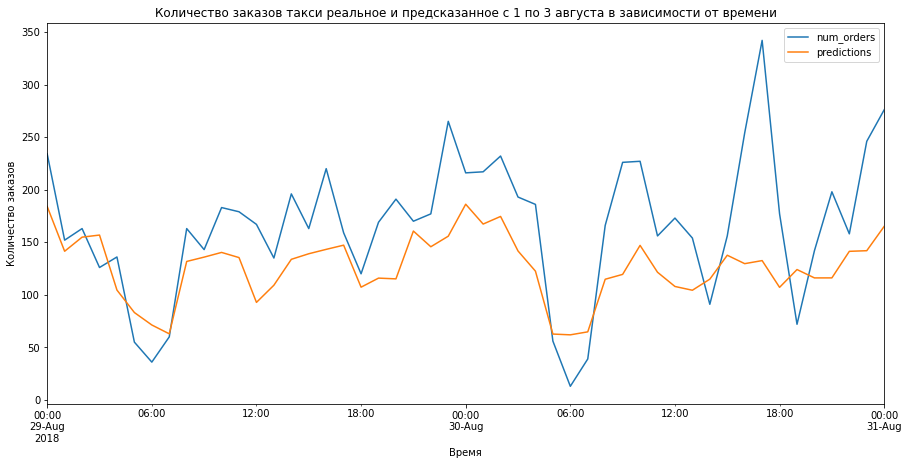

In [49]:
plot_predict = test.copy()
plot_predict['predictions'] = predictions
plot_predict['2018-08-29 00:00':'2018-08-31 00:00'].plot(y=['num_orders', 'predictions'], figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси реальное и предсказанное с 1 по 3 августа в зависимости от времени')
plt.show()

Видно, что модель достаточно близко предсказывает количество заказов, за исключением пиковых значений. График предсказаний на некоторых участках практически повторяет график реальных значений со сдвигом по оси.

## Итоги

Таким образом, в ходе исследования:

1. Были загружены, изучены и ресемплированы данные по количеству заказов такси;
2. Подготовлены признаки для обучения: добавлены год, месяц, день, день недели, отстающие значения и скользящее среднее; Подобрано количество отстающих значений и размер окна для скользящего среднего;
3. Обучены модели линейной регрессии, решающего дерева, случайного леса и CatBoost; подобраны гиперпараметры, для которых RMSE на обучающей выборке минимальное;
4. На обучающей выборке наилучший результат показал CatBoost;
5. Протестирована модель CatBoost, показавшая на обучающей выборке лучший результат. На тестовой выборке RMSE оказалось равным 46.99, результат можно считать удовлетворительным (при количестве итераций 50, глубине 10 и скорости обучения 0.3).

В итоге в качестве модели для предсказания количества заказов такси на следующий час выбран CatBoost с количеством итераций 50, глубиной 10 и скоростью обучения 0.3.

<br>

[В начало](#start)